In [1]:
import re
import numpy as np
import pandas as pd
from scipy.io import loadmat
import matplotlib.pyplot as plt
from sklearn.svm import SVC

from nltk.stem import PorterStemmer
from nltk.tokenize import word_tokenize
%matplotlib inline

## Support Vector Machines

In [126]:
def plotData(x, y, t):
    plt.plot(x[(y==1), 0], x[(y==1), 1], 'k+', x[(y==0), 0], x[(y==0), 1], 'yo')
    plt.title(t)

In [128]:
def plotLinear(model, x, y, t):
    x1_bound = np.linspace(min(x[:,0]), max(x[:,0]), 50)
    x2_bound = - (model.intercept_ + model.coef_[0][0] * x1_bound) / model.coef_[0][1]

    plotData(x, y, t)
    plt.plot(x1_bound, x2_bound, 'b-')
    plt.show()

In [135]:
def plotBoundary(model, x, y, t, custom_gauss=False):
    plotData(x, y, t)

    # plot the decision function
    ax = plt.gca()
    xlim = ax.get_xlim()
    ylim = ax.get_ylim()

    # create grid to evaluate model
    xx = np.linspace(xlim[0], xlim[1], 30)
    yy = np.linspace(ylim[0], ylim[1], 30)
    YY, XX = np.meshgrid(yy, xx)
    xy = np.vstack([XX.ravel(), YY.ravel()]).T
    if custom_gauss:
        Z = model.predict(gaussianKernelGramMatrixFull(xy, x)).reshape(XX.shape)
    else:
        Z = model.predict(xy).reshape(XX.shape)

    # plot decision boundary and margins
    ax.contour(XX, YY, Z, [0])
    plt.show()

### Example Dataset 1

In [3]:
data1 = loadmat('ex6/ex6data1.mat')

X1 = data1['X']
y1 = data1['y'].ravel()

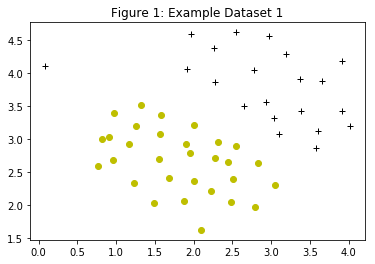

In [129]:
plotData(X1, y1, 'Figure 1: Example Dataset 1')
plt.show()

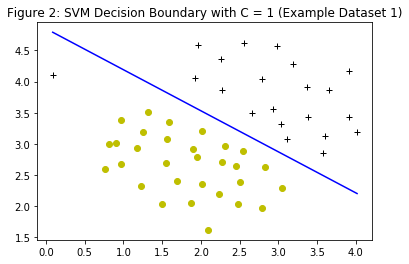

In [130]:
clf1 = SVC(kernel='linear', C=1)
clf1.fit(X1, y1)

plotLinear(clf1, X1, y1, 'Figure 2: SVM Decision Boundary with C = 1 (Example Dataset 1)')

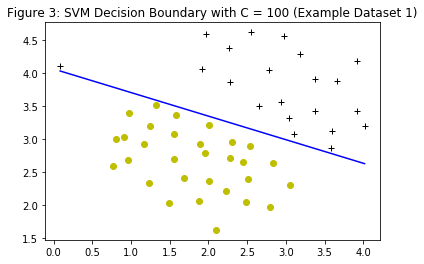

In [131]:
clf1.set_params(C=100)
clf1.fit(X1, y1)

plotLinear(clf1, X1, y1, 'Figure 3: SVM Decision Boundary with C = 100 (Example Dataset 1)')

### SVM with Gaussian Kernels

### Gaussian Kernel

In [88]:
def gaussianKernel(x1, x2, sigma):
    dist = np.subtract(x1, x2)
    return np.exp(- np.dot(dist.T, dist) / (2 * sigma**2))

In [89]:
x1 = [1, 2, 1]
x2 = [0, 4, -1]
sigma = 2
print('Gaussian Kernel between x1 = [1; 2; 1], x2 = [0; 4; -1], sigma = {}: {}'
      '\n(for sigma = 2, this value should be about 0.324652)'.format(sigma, round(gaussianKernel(x1, x2, sigma), 6)))

Gaussian Kernel between x1 = [1; 2; 1], x2 = [0; 4; -1], sigma = 2: 0.324652
(for sigma = 2, this value should be about 0.324652)


### Example Dataset 2

In [74]:
data2 = loadmat('ex6/ex6data2.mat')

X2 = data2['X']
y2 = data2['y'].ravel()
X2.shape

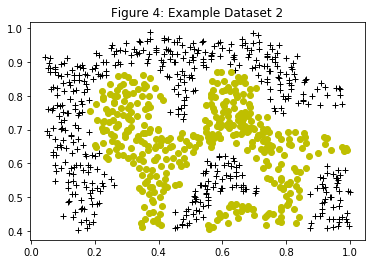

In [132]:
plotData(X2, y2, 'Figure 4: Example Dataset 2')
plt.show()

In [118]:
# https://stackoverflow.com/questions/26962159/how-to-use-a-custom-svm-kernel
def gaussianKernelGramMatrixFull(X1, X2, sigma=0.1):
    """(Pre)calculates Gram Matrix K"""

    gram_matrix = np.zeros((X1.shape[0], X2.shape[0]))
    for i, x1 in enumerate(X1):
        for j, x2 in enumerate(X2):
            x1 = x1.flatten()
            x2 = x2.flatten()
            gram_matrix[i, j] = np.exp(- np.sum( np.power((x1 - x2),2) ) / float( 2*(sigma**2) ) )
    return gram_matrix

C=0.1
clf2 = SVC(C = C, kernel="precomputed")
clf2.fit(gaussianKernelGramMatrixFull(X2,X2), y2)

SVC(C=0.1, cache_size=200, class_weight=None, coef0=0.0,
  decision_function_shape='ovr', degree=3, gamma='auto',
  kernel='precomputed', max_iter=-1, probability=False, random_state=None,
  shrinking=True, tol=0.001, verbose=False)

C:\Users\Owner\Anaconda3\lib\site-packages\matplotlib\contour.py:1180: UserWarning: No contour levels were found within the data range.
  warnings.warn("No contour levels were found"


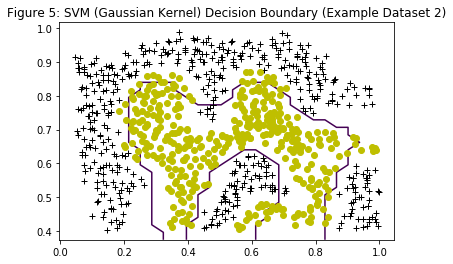

In [136]:
plotBoundary(clf2, X2, y2, 'Figure 5: SVM (Gaussian Kernel) Decision Boundary (Example Dataset 2)', custom_gauss=True)

C:\Users\Owner\Anaconda3\lib\site-packages\matplotlib\contour.py:1180: UserWarning: No contour levels were found within the data range.
  warnings.warn("No contour levels were found"


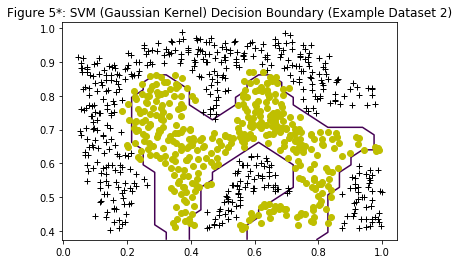

In [140]:
sigma = 0.1
clf3 = SVC(C=0.1, kernel='rbf', gamma=np.power(sigma, -2.0))
clf3.fit(X2, y2)

plotBoundary(clf3, X2, y2, 'Figure 5*: SVM (Gaussian Kernel) Decision Boundary (Example Dataset 2)')

### Example Dataset 3

In [145]:
data3 = loadmat('ex6/ex6data3.mat')

X3 = data3['X']
y3 = data3['y'].ravel()
X3_val = data3['Xval']
y3_val = data3['yval'].ravel()

In [158]:
def dataset3Params(x, y, xval, yval, c_list, sigma_list):
    best_parm = None
    best_accuracy = 0
    model = SVC(kernel='rbf')
    for c in c_list:
        for sigma in sigma_list:
            model.set_params(C=c, gamma=np.power(sigma, -2.0))
            model.fit(x, y)
            accuracy = model.score(xval, yval)
            if accuracy > best_accuracy:
                best_parm = (c, sigma)                
                best_accuracy = accuracy
    return (best_parm, best_accuracy)

In [159]:
CS = [0.01, 0.03, 0.1, 0.3, 1, 3, 10, 30]
SIGMAS = [0.25, 0.5, 0.75, 1, 1.25, 1.5, 1.75, 2]

op = dataset3Params(X3, y3, X3_val, y3_val, CS, SIGMAS)

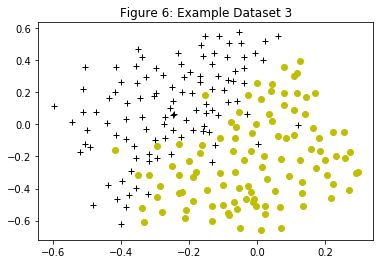

In [160]:
plotData(X3, y3, 'Figure 6: Example Dataset 3')

In [162]:
op_clf = SVC(C=op[0][0], kernel='rbf', gamma=np.power(op[0][1], -2.0))
op_clf.fit(X3, y3)

SVC(C=10, cache_size=200, class_weight=None, coef0=0.0,
  decision_function_shape='ovr', degree=3, gamma=16.0, kernel='rbf',
  max_iter=-1, probability=False, random_state=None, shrinking=True,
  tol=0.001, verbose=False)

C:\Users\Owner\Anaconda3\lib\site-packages\matplotlib\contour.py:1180: UserWarning: No contour levels were found within the data range.
  warnings.warn("No contour levels were found"


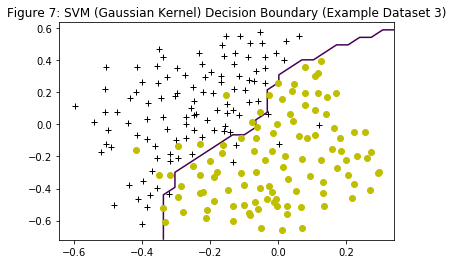

In [163]:
plotBoundary(op_clf, X3, y3, 'Figure 7: SVM (Gaussian Kernel) Decision Boundary (Example Dataset 3)')

## Spam Classification

### Processing Emails

In [2]:
# vocabulary list
vocabDict = {}

with open('ex6/vocab.txt', 'r') as f:
    for line in f.readlines():
        li = line.strip().split('\t')
        vocabDict[li[1]] = int(li[0])
print(len(vocabDict))

1899


In [3]:
def processEmail(email_contents):
    word_indices = []
    # lowercase
    email_contents = str(email_contents).lower()
    # strip all HTML, replace any < ... > with space and does not have any < or > in the tag
    email_contents = re.sub(r'<[^<>]+>', ' ', email_contents)
    # numbers
    email_contents = re.sub(r'[0-9]+', 'number', email_contents)
    # urls
    email_contents = re.sub(r'(http|https)://[^\s]*', 'httpaddr', email_contents)
    # email addresses
    email_contents = re.sub(r'[^\s]+@[^\s]+', 'emailaddr', email_contents)
    # $ sign
    email_contents = re.sub(r'[$]+', 'dollar', email_contents)
    # remove non alphanumeric characters
    email_contents = re.sub(r'[^a-zA-Z0-9]', ' ', email_contents)
    # word stemming
    words = []
    ps = PorterStemmer()
    for w in word_tokenize(email_contents):
        stemmed = ps.stem(w)
        words.append(stemmed)
        if len(stemmed) > 1:
            try:
                index = vocabDict[stemmed]
                word_indices.append(index)
            except KeyError as e:
                continue
    return (word_indices, ' '.join(words))

In [88]:
with open('ex6/emailSample1.txt', 'r+') as f:
    sample1 = f.read()
    
index, sentence = processEmail(sample1)
print(sentence)
print(index)

anyon know how much it cost to host a web portal well it depend on how mani visitor you re expect thi can be anywher from less than number buck a month to a coupl of dollarnumb you should checkout httpaddr or perhap amazon ecnumb if your run someth big to unsubscrib yourself from thi mail list send an email to emailaddr
[86, 916, 794, 1077, 883, 370, 1699, 790, 1822, 1831, 883, 431, 1171, 794, 1002, 1893, 1364, 592, 1676, 238, 162, 89, 688, 945, 1663, 1120, 1062, 1699, 375, 1162, 479, 1893, 1510, 799, 1182, 1237, 810, 1895, 1440, 1547, 181, 1699, 1758, 1896, 688, 1676, 992, 961, 1477, 71, 530, 1699, 531]


### Extracting Features from Emails

In [4]:
def emailFeatures(word_indices, n=1899):
    feature = [0] * n
    for i in set(word_indices):
        # vocab list file index starts from 1, need -1 for better indexing
        feature[i - 1] = 1
    return feature

In [100]:
sample_feature = emailFeatures(index)
print("Length of feature: ", len(sample_feature))
print("Should have 45 non-zero entries: ", sum(sample_feature))

Length of feature:  1899
Should have 45 non-zero entries:  45


### Training SVM for Spam Classification

In [103]:
spamTrain = loadmat('ex6/spamTrain.mat')
spamTest = loadmat('ex6/spamTest.mat')

X = spamTrain['X']
y = spamTrain['y'].ravel()
Xtest = spamTest['Xtest']
ytest = spamTest['ytest'].ravel()
print(X.shape)
print(Xtest.shape)

(4000, 1899)
(1000, 1899)


In [105]:
clf = SVC(C=0.1, kernel='linear')
clf.fit(X, y)
print("Training Accuracy: ", clf.score(X, y))

Training Accuracy:  0.99825


In [106]:
print("Test Accuracy: ", clf.score(Xtest, ytest))

Test Accuracy:  0.989


### Top Predictors for Spam

In [133]:
top15_idx = np.argsort(clf.coef_[0])[::-1][:15] + 1 # since vocabDict index start from 1 not 0
print(' '.join([k for k in vocabDict.keys() if vocabDict[k] in top15_idx]))

basenumb click dollar ga guarante hour lo most nbsp our pleas price remov visit will


### Try sample emails

In [136]:
# read in sample files
samples = []
for filename in ['emailSample1.txt', 'emailSample2.txt', 'spamSample1.txt', 'spamSample2.txt']:
    with open('ex6/'+filename, 'r+') as f:
        samples.append(f.read())

In [143]:
features = []
for sample in samples:   
    index = processEmail(sample)[0]
    features.append(emailFeatures(index))
    
print("vocab occuracnce", [sum(i) for i in features])

vocab occuracnce [45, 128, 48, 19]


In [155]:
Xsample = np.array(features)
print("Result should be [0, 0, 1, 1] as we know first two are non-spam and last two are spam emails.")
print(clf.predict(Xsample))

Result should be [0, 0, 1, 1] as we know first two are non-spam and last two are spam emails.
[0 0 1 1]


### Build your own dataset

In [39]:
# just using 2003 data
import os
from sklearn.model_selection import train_test_split
data_path = 'ex6/spamassassin_data/'

In [33]:
def read_contents(path):
    files = os.listdir(path)
    contents = []
    for file in files:
        with open(os.path.join(path, file), 'r', errors='ignore') as f:
            contents.append(f.read())
    return contents

In [34]:
def processData(paths, labels):
    X = []
    y = []
    for p, l in zip(paths, labels):
        emails = read_contents(p)
        n = len(emails)
        print(n)
        for email in emails:
            index = processEmail(email)[0]
            X.append(emailFeatures(index))
        y.extend([l] * n)
    return (X, y)

In [35]:
subdirs = [data_path + subdir for subdir in os.listdir(data_path)]
print(subdirs)

['ex6/spamassassin_data/easy_ham', 'ex6/spamassassin_data/easy_ham_2', 'ex6/spamassassin_data/hard_ham', 'ex6/spamassassin_data/spam', 'ex6/spamassassin_data/spam_2']


In [36]:
X, y = processData(subdirs, [0,0,0,1,1])

2501
1401
251
501
1398


In [46]:
X = np.array(X)
y = np.array(y)
print(X.shape, y.shape)

(6052, 1899) (6052,)


In [50]:
Xtrain, Xtest, ytrain, ytest = train_test_split(X, y, test_size=0.4, random_state=2018)
Xval, Xtest, yval, ytest = train_test_split(Xtest, ytest, test_size=0.5, random_state=2018)
print(Xtrain.shape, Xval.shape, Xtest.shape)

(3631, 1899) (1210, 1899) (1211, 1899)


In [59]:
clf = SVC(C=0.1, kernel='linear')
clf.fit(Xtrain, ytrain)
print("Training Accuracy: ", clf.score(X, y))

Training Accuracy:  0.992233972241


In [62]:
def linearSpamSVM(xtrain, ytrain, xval, yval, parms, verbose=True):
    clf = SVC(kernel='linear')
    best_model = None
    best_c = None
    best_val_accuracy = 0
    for c in parms:
        clf.set_params(C=c)
        clf.fit(xtrain, ytrain)
        val_accuracy = clf.score(xval, yval)
        if val_accuracy > best_val_accuracy:
            best_model = clf
            best_c = c
            best_val_accuracy = val_accuracy
        if verbose:
            train_accuracy = clf.score(xtrain, ytrain)
            print("Parmameter: {}\tTraining Accuracy: {}\tValidation Accuracy: {}".format(c, train_accuracy, val_accuracy))
    return best_model, best_c

In [63]:
c_list = [0.01, 0.03, 0.06, 0.1, 0.3, 1, 3, 10]
b_model, b_c = linearSpamSVM(Xtrain, ytrain, Xval, yval, c_list)

Parmameter: 0.01	Training Accuracy: 0.994216469292206	Validation Accuracy: 0.9859504132231405
Parmameter: 0.03	Training Accuracy: 0.9986229688790966	Validation Accuracy: 0.9884297520661157
Parmameter: 0.06	Training Accuracy: 0.9994491875516387	Validation Accuracy: 0.987603305785124
Parmameter: 0.1	Training Accuracy: 1.0	Validation Accuracy: 0.9884297520661157
Parmameter: 0.3	Training Accuracy: 1.0	Validation Accuracy: 0.9884297520661157
Parmameter: 1	Training Accuracy: 1.0	Validation Accuracy: 0.9884297520661157
Parmameter: 3	Training Accuracy: 1.0	Validation Accuracy: 0.9884297520661157
Parmameter: 10	Training Accuracy: 1.0	Validation Accuracy: 0.9884297520661157


In [64]:
# performance on test set
b_model.score(Xtest, ytest)

0.97192402972749792